# Libpysal neigbors

In [1]:
import libpysal.api as lp
import libpysal
from libpysal import examples
import matplotlib.pyplot as plt
import geopandas as gpd
%matplotlib inline

In [2]:
from importlib import reload
reload(libpysal)

<module 'libpysal' from '/Users/steffie/code/libpysal/libpysal/__init__.py'>

In [3]:
examples.explain('rio_grande_do_sul')

{'name': 'Rio_Grande_do_Sul',
 'description': 'Cities of the Brazilian State of Rio Grande do Sul',
 'explanation': ['* 43MUE250GC_SIR.dbf: attribute data (k=2)',
  '* 43MUE250GC_SIR.shp: Polygon shapefile (n=499)',
  '* 43MUE250GC_SIR.shx: spatial index',
  '* 43MUE250GC_SIR.cpg: encoding file ',
  '* 43MUE250GC_SIR.prj: projection information ',
  '* map_RS_BR.dbf: attribute data (k=3)',
  '* map_RS_BR.shp: Polygon shapefile (no lakes) (n=497)',
  '* map_RS_BR.prj: projection information',
  '* map_RS_BR.shx: spatial index',
  'Source: Renan Xavier Cortes <renanxcortes@gmail.com>',
  'Reference: https://github.com/pysal/pysal/issues/889#issuecomment-396693495']}

In [4]:
gdf = gpd.read_file(examples.get_path('43MUE250GC_SIR.shp'))
gdf.head()

,NM_MUNICIP,CD_GEOCMU,geometry
0,LAGOA MIRIM,4300001,POLYGON ((-52.6224061101419 -32.14661509114978...
1,ACEGUÁ,4300034,POLYGON ((-54.10940375660775 -31.4331615329298...
2,ÁGUA SANTA,4300059,POLYGON ((-51.98932089399999 -28.1294290447850...
3,AGUDO,4300109,POLYGON ((-53.13695617099998 -29.4948277498090...
4,AJURICABA,4300208,POLYGON ((-53.61993058200001 -28.1456914857853...


In [5]:
weights = lp.Queen.from_dataframe(gdf)

/Users/steffie/code/libpysal/libpysal/weights/weights.py:189: UserWarning: There are 30 disconnected observations
  warnings.warn("There are %d disconnected observations" % ni)
/Users/steffie/code/libpysal/libpysal/weights/weights.py:190: UserWarning: Island ids: 0, 1, 5, 24, 28, 81, 95, 102, 108, 110, 120, 123, 140, 170, 176, 224, 240, 248, 254, 255, 256, 257, 262, 277, 292, 295, 304, 322, 358, 375
  warnings.warn("Island ids: %s" % ', '.join(str(island) for island in self.islands))


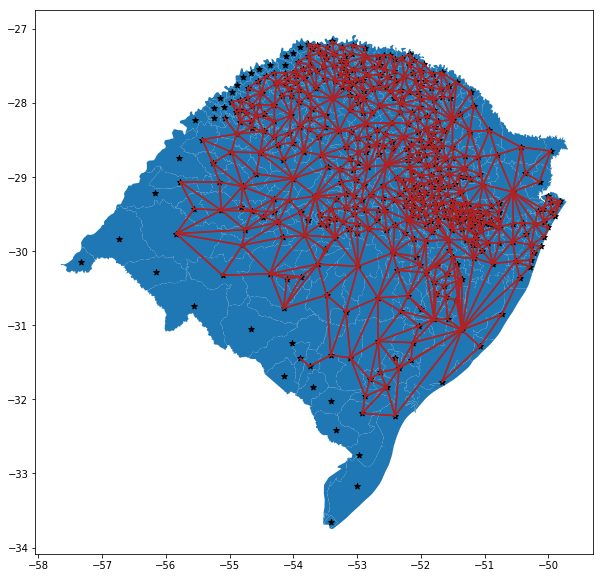

In [6]:
fig, ax = plt.subplots(1, figsize=(10,10))
gdf.plot(ax=ax)
weights.plot(gdf, color='firebrick', node_kws=dict(marker='*', color='k'), ax=ax)
plt.show()

In [7]:
wnp = libpysal.weights.util.nonplanar_neighbors(weights, gdf)

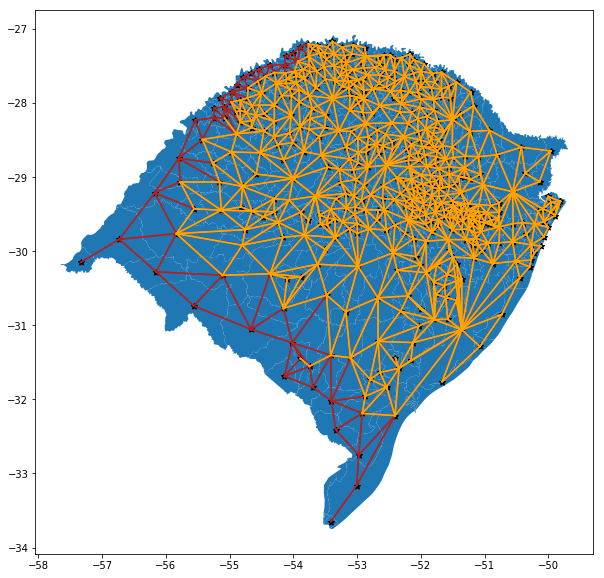

In [9]:
fig, ax = plt.subplots(1, figsize=(10,10))
gdf.plot(ax=ax)
wnp.plot(gdf, color='firebrick', node_kws=dict(marker='*', color='k'), ax=ax)
weights.plot(gdf, color='orange', node_kws=dict(marker='*', color='k'), ax=ax)
plt.show()

In [10]:
import numpy as np

def plot_new_joins1(w, gdf, indexed_on=None, ax=None, color='k',
         node_kws=None, edge_kws=None):
    try:
        import matplotlib.pyplot as plt
    except ImportError:
        raise ImportError("W.plot depends on matplotlib.pyplot, and this was"
                          "not able to be imported. \nInstall matplotlib to"
                          "plot spatial weights.")
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    else:
        fig = ax.get_figure()
    if node_kws is not None:
        if 'color' not in node_kws:
            node_kws['color'] = color
    else:
        node_kws=dict(color=color)
    if edge_kws is not None:
        if 'color' not in edge_kws:
            edge_kws['color'] = color
    else:
        edge_kws=dict(color=color)
    
    for idx, non_planar_new_joins in w:
        if idx in w.islands:
            continue
        if indexed_on is not None:
            non_planar_new_joins = gdf[gdf[indexed_on].isin(non_planar_new_joins)].index.tolist()
            idx = gdf[gdf[indexed_on] == idx].index.tolist()[0]
        centroids = gdf.loc[non_planar_new_joins].centroid.apply(lambda p: (p.x, p.y))
        centroids = np.vstack(centroids.values)
        focal = np.hstack(gdf.loc[idx].geometry.centroid.xy)
        seen = set()
        for nidx, neighbor in zip(non_planar_new_joins, centroids):
            if (idx,nidx) in seen:
                continue
            ax.plot(*list(zip(focal, neighbor)), marker=None,
                    **edge_kws)
            seen.update((idx,nidx))
            seen.update((nidx,idx))
    ax.scatter(gdf.centroid.apply(lambda p: p.x),
               gdf.centroid.apply(lambda p: p.y),
               **node_kws)
    return fig, ax


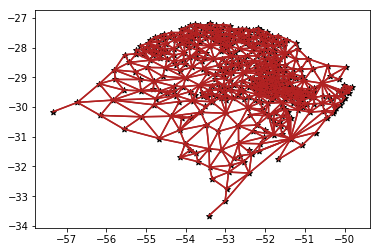

In [11]:
plot_new_joins1(wnp, gdf, color='firebrick', node_kws=dict(marker='*', color='k'))
plt.show()

In [ ]:
wnp.neighbors

In [41]:
import numpy as np

def plot_new_joins2(w, gdf):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    for idx, non_planar_new_joins in w:
        if idx in w.islands:
            continue
        centroids = gdf.loc[non_planar_new_joins].centroid.apply(lambda p: (p.x, p.y))
        centroids = np.vstack(centroids.values)
        focal = np.hstack(gdf.loc[idx].geometry.centroid.xy)
        seen = set()
        for nidx, neighbor in zip(non_planar_new_joins, centroids):
            if (idx,nidx) in seen:
                continue
            ax.plot(*list(zip(focal, neighbor)), marker=None)
            seen.update((idx,nidx))
            seen.update((nidx,idx))
    ax.scatter(gdf.centroid.apply(lambda p: p.x),
               gdf.centroid.apply(lambda p: p.y))
    return fig, ax

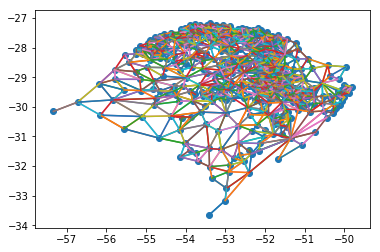

In [42]:
plot_new_joins2(wnp, gdf)
plt.show()

In [50]:
for idx, non_planar_new_joins in wnp:
    if idx in wnp.islands:
        continue
    centroids = gdf.loc[non_planar_new_joins].centroid.apply(lambda p: (p.x, p.y))
    centroids = np.vstack(centroids.values)
    focal = np.hstack(gdf.loc[idx].geometry.centroid.xy)
    seen = set()

In [55]:
centroids = gdf.loc[non_planar_new_joins]
centroids

,NM_MUNICIP,CD_GEOCMU,geometry
401,BOM PRINCÍPIO,4302352,"POLYGON ((-51.332049344 -29.40986993580758, -5..."
324,SÃO PEDRO DA SERRA,4319356,POLYGON ((-51.43550672100001 -29.4318843608079...
488,HARMONIA,4309555,POLYGON ((-51.43883934699997 -29.5160656228093...
283,SALVADOR DO SUL,4316501,POLYGON ((-51.47229869800005 -29.4386990798081...
316,SÃO JOSÉ DO SUL,4318614,POLYGON ((-51.45741609999994 -29.4957232688091...
478,BARÃO,4301651,POLYGON ((-51.3971671229999 -29.35156280980666...


In [56]:
centroids = np.vstack(centroids.values)
centroids

array([['BOM PRINCÍPIO', '4302352',
       ['SÃO PEDRO DA SERRA', '4319356',
       ['HARMONIA', '4309555',
       ['SALVADOR DO SUL', '4316501',
       ['SÃO JOSÉ DO SUL', '4318614',
       ['BARÃO', '4301651',
      dtype=object)

In [57]:
focal = np.hstack(gdf.loc[idx].geometry.centroid.xy)
focal

array([-51.42675898, -29.47442398])